In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import sem

#%% Plot Tong's default setting
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
    return fig_dims

In [2]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("data.pickle","rb")
metagenome_ID, metagenome, metabolome_ID, metabolome = pickle.load(pickle_in)


## Create maps of microbes and metabolites to their reduced matrix forms

In [3]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()
net_temp = net.copy()
net['edgeType'][net['edgeType']==5] = 2
net_temp['edgeType'][net_temp['edgeType']==5] = 3
net = net.append(net_temp).drop_duplicates()
net_ori = net.copy()

metagenome_ID_reduced = df_microbes.loc[metagenome_ID].values.flatten()
metagenome_ID = metagenome_ID_reduced[~np.isnan(metagenome_ID_reduced)].astype(int)

metabolome_ID_reduced = df_metabolites.loc[metabolome_ID].values.flatten()
metabolome_ID = metabolome_ID_reduced[~np.isnan(metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [4]:
for i in range(1,101):
    df_added = pd.read_csv("./cluster_simulation_add/added_links_prior_distribution_run"+str(i)+".csv", index_col=0)
    #df_added['metabolites'] = df_metabolites.loc[df_added['metabolite ID']].values
    #df_added['microbes'] = df_microbes.loc[df_added['microbes ID']].values
    #df_added_net = df_added[['metabolites','microbes','edgeType']]
    #df_added_net.head()
    if i == 1:
        df_added_all = df_added.copy()
    else:
        df_added_all = pd.concat([df_added_all, df_added])

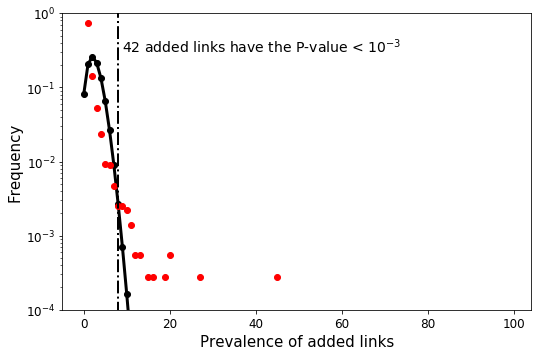

In [75]:
from collections import Counter
from scipy.stats import bernoulli, binom
NUMSIM = 100
xx = range(NUMSIM)
p = len(df_added_all) / 100 / len(net_ori)
probCum = binom.cdf(xx, NUMSIM, p)
prob = binom.pmf(xx, NUMSIM, p)
threshold = np.where(probCum > 1 - 1e-3)[0][0]

prevalence = Counter(df_added_all['position in x'])
numOfSigLinks = np.sum(np.array(list(prevalence.values())) >= threshold)

prevalence = Counter(prevalence.values())
fig_dims = figure_size_setting(700)
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
axes.plot(xx, prob, 'ko-', lw=3)
axes.plot(list(prevalence.keys()), list(prevalence.values())/np.sum(list(prevalence.values())), 'ro')
axes.plot([threshold, threshold], [0, 1], 'k-.', lw=2)
axes.text(threshold+1, 0.3, str(numOfSigLinks)+' added links have the P-value < $10^{-3}$', size=14);
axes.set_yscale('log')
axes.set_ylim([1e-4, 1])
axes.set_xlabel('Prevalence of added links')
axes.set_ylabel('Frequency')
fig.subplots_adjust(left=.13, bottom=.11, right=.97, top=.97, hspace=0.2)
fig.savefig("./prevalence_of_added_links_HMP.pdf", dpi=600)

In [76]:
i_prevalent = df_added_all.groupby('position in x').apply(len) 
df_prevalence = df_added_all.set_index('position in x').loc[i_prevalent[i_prevalent >= threshold].index]
df_prevalence = df_prevalence[['metabolite ID', 'metabolite names', 'microbes ID', 'microbes names', 'edgeType']].drop_duplicates()
df_prevalence['prevalence'] = i_prevalent.loc[df_prevalence.index]
df_prevalence.to_csv('prevalent_added_links_HMP.csv', index=None)
df_prevalence

,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,prevalence
position in x,,,,,,
2055,2011,4-Aminobutyrate (GABA),411,Dialister invisus,2,9
6341,2035,Biotin (Vitamin B7),54,Alistipes putredinis,2,10
6411,2035,Biotin (Vitamin B7),411,Dialister invisus,2,19
6934,2038,Butyrate,46,Akkermansia muciniphila,2,9
6961,2038,Butyrate,136,Bacteroides vulgatus,2,10
6971,2038,Butyrate,158,Bifidobacterium pseudocatenulatum,2,9
7010,2038,Butyrate,436,Enterobacter cloacae,2,11
14419,2081,Deoxycholic acid,966,Ruminococcus gnavus,2,15
18974,2107,H2 (Hydrogen),967,Ruminococcus lactaris,2,8


In [93]:
df_added_all_ind = []
for i in range(1,101):
    df_added = pd.read_csv("./cluster_simulation_add/added_links_prior_distribution_run"+str(i)+".csv", index_col=0)
    df_added_all_ind = df_added_all_ind + [df_added]

In [96]:
error_reduction_array = np.zeros((100, 10000))
for i, df in enumerate(df_added_all_ind):
    error_reduction_array[i, df['step added'].values] = df['error reduced'].values

from scipy.stats import sem
log10_error_array = 1.007245-np.cumsum(error_reduction_array,1)
y_est = np.mean(log10_error_array, 0)
y_err = sem(log10_error_array, 0)
x = range(log10_error_array.shape[1])

fig_dims = figure_size_setting(800)
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
axes.plot(x, y_est, '-', color=color_list[0])
axes.fill_between(x, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='grey')
axes.set_xlim([0, 3000])
axes.set_xlabel('GutCP simulation step')
axes.set_ylabel('Log10 error between predicted and \n experimentally measured metabolome')

fig.subplots_adjust(left=.13, bottom=.11, right=.97, top=.95, hspace=0.2)
fig.savefig("./temporal_dynamics_for_GutCP_on_HMP.pdf", dpi=600)

In [79]:
from scipy.stats import kruskal
from scipy.stats import ttest_ind
def annotate_kruskal_wallis_test(i1, i2, y, axes):
    x1, x2 = i1+1, i2+1
    #plt.plot([x1, x2], [y, y], lw=1.0, c='k')
    h=0.02
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c='k')
    pvalue = ttest_ind(data_to_boxplot[i1], data_to_boxplot[i2])[1]
    if pvalue > 0.05:
        axes.text((x1+x2)*.5, y+h*0.8, "ns", ha='center', va='bottom', color='k', fontsize=14)
    elif pvalue > 0.01:
        axes.text((x1+x2)*.5, y+h*0.8, "*", ha='center', va='bottom', color='k', fontsize=14)
    elif pvalue > 0.001:
        axes.text((x1+x2)*.5, y+h*0.8, "**", ha='center', va='bottom', color='k', fontsize=14)
    else:
        axes.text((x1+x2)*.5, y+h*0.8, "***", ha='center', va='bottom', color='k', fontsize=14)

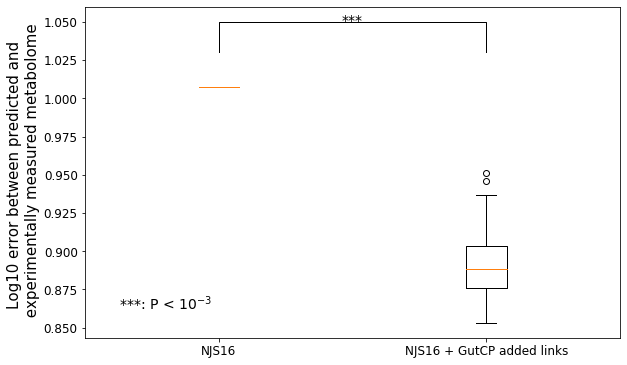

In [80]:
total_log10_error = 1.007245-np.array(list(map(lambda x: x['error reduced'].cumsum().iloc[-1], df_added_all_ind)))
total_log10_error

fig_dims = figure_size_setting(800)
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
data_to_boxplot = [[1.007245]*100, total_log10_error]
axes.boxplot(data_to_boxplot);
axes.set_ylabel('Log10 error between predicted and \n experimentally measured metabolome')
axes.set_xticks(range(1,3))
axes.set_xticklabels(['NJS16', 'NJS16 + GutCP added links'])
annotate_kruskal_wallis_test(0, 1, 1.03, axes)
axes.text(0.8, 0.86, "***: P < $10^{-3}$", ha='center', va='bottom', color='k', fontsize=14)

fig.subplots_adjust(left=.13, bottom=.11, right=.97, top=.95, hspace=0.2)
fig.savefig("./performance_addition_for_HMP.pdf", dpi=600)